In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [2]:
data = np.loadtxt('covtype.data', delimiter=',')
#data = np.loadtxt('covtype_7000.data', delimiter=',')

In [3]:
# Find the most common classes
count = Counter(data[:,54])
print(count.most_common(3))

[(2.0, 283301), (1.0, 211840), (3.0, 35754)]


In [4]:
for i in range(len(data[:,54])):
    if data[i,54] == 2:
        data[i,54] = 1
    else:
        data[i,54] = 0

In [5]:
print(data)
print(data.shape)

data_continuous = data[:,0:10]
d_s = StandardScaler()
d_n = d_s.fit_transform(data_continuous)

X_and_Y = np.hstack([d_n, data[:,10:56]])
print(X_and_Y)

[[  2.59600000e+03   5.10000000e+01   3.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.59000000e+03   5.60000000e+01   2.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.80400000e+03   1.39000000e+02   9.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 ..., 
 [  2.38600000e+03   1.59000000e+02   1.70000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.38400000e+03   1.70000000e+02   1.50000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.38300000e+03   1.65000000e+02   1.30000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
(581012, 55)
[[-1.29780509 -0.93515698 -1.48281978 ...,  0.          0.          0.        ]
 [-1.31923485 -0.89047967 -1.61636259 ...,  0.          0.          0.        ]
 [-0.5549068  -0.14883628 -0.68156292 ...,  0.          0.          1.        ]
 ..., 
 [-2.04784663  0.02987297  0.38677957 ...,  0.          0.  

In [6]:
# Divide data into training and testing sets

np.random.shuffle(X_and_Y)

# Try to predict the last column (the cover type, which is 7 types)
# NOTE: the largest number is "positive", while the other ones count as negative. This way it is a binary classification problem
X = X_and_Y[:5000,0:-1]
Y = X_and_Y[:5000,-1]
print(X.shape, Y.shape)

(5000, 54) (5000,)


In [7]:
X_train_val = X[:int(0.2*len(X))]
X_test      = X[int(0.2*len(X)):]
Y_train_val = Y[:int(0.2*len(Y))]
Y_test      = Y[int(0.2*len(Y)):]

print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(1000, 54) (4000, 54) (1000,) (4000,)


In [8]:
# SVM process

# linear
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='linear')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]   
params = {"C": C_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([  0.04843192,   0.04913421,   0.04763365,   0.0511363 ,
          0.05263772,   0.04112859,   0.04172935,   0.05233679,
          0.19854059,   1.61334734,  19.23883986]),
 'mean_score_time': array([ 0.00910988,  0.00960689,  0.00920682,  0.01000705,  0.01090741,
         0.00840573,  0.00750527,  0.00610461,  0.00600462,  0.0060039 ,
         0.00560374]),
 'mean_test_score': array([ 0.516,  0.516,  0.516,  0.516,  0.517,  0.654,  0.716,  0.75 ,
         0.761,  0.762,  0.762]),
 'mean_train_score': array([ 0.51600001,  0.51600001,  0.51600001,  0.51600001,  0.51700032,
         0.66999886,  0.74274765,  0.77825079,  0.79325081,  0.79625268,
         0.79675237]),
 'param_C': masked_array(data = [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0 1000.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1e-07},
  {'C': 1e-06},
  {'C': 1e-05},
  {'C': 0.0001},
  {'C': 0.001}

In [9]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 100.0}
0.7505


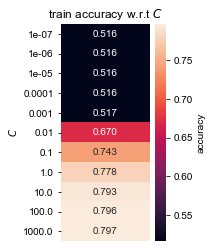

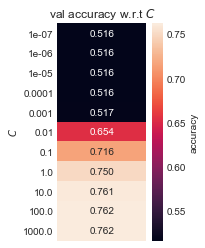

In [10]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
results = GSR.cv_results_

train_acc = np.matrix(results.get("mean_train_score")).T
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = np.matrix(results.get("mean_test_score")).T
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [11]:
def convert_to_gamma(radial_width):
    converted = [0]*len(radial_width)
    for i in range(len(radial_width)):
        gamma = 1/(2*(radial_width[i]**2))
        converted[i] = gamma
    return converted

radial_width = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
gamma_list = convert_to_gamma(radial_width)

# SVM process

# rbf
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='rbf')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]
params = {"C": C_list, "gamma": gamma_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([ 0.08425884,  0.083459  ,  0.07855568,  0.08015685,  0.15380888,
         0.07825537,  0.06594701,  0.06604605,  0.08546066,  0.08706136,
         0.0904635 ,  0.10157127,  0.1811275 ,  0.09426575,  0.06944971,
         0.07075009,  0.09296627,  0.10368433,  0.10627513,  0.1066772 ,
         0.17532396,  0.09076943,  0.07766833,  0.07905617,  0.09136515,
         0.092765  ,  0.09829021,  0.10777626,  0.17682533,  0.09016409,
         0.07335253,  0.07275143,  0.08476038,  0.08456306,  0.08696136,
         0.09076371,  0.1536088 ,  0.07657146,  0.06524649,  0.0650465 ,
         0.08926253,  0.08556032,  0.08556037,  0.09836888,  0.15961208,
         0.08035583,  0.06814885,  0.06864796,  0.08776584,  0.08405938,
         0.08686113,  0.08976316,  0.16071205,  0.08495994,  0.07295146,
         0.06604667,  0.09076371,  0.08986397,  0.09546733,  0.10077109,
         0.16511636,  0.09586782,  0.08395872,  0.06294451,  0.11468434,
         0.12448783,  0.10527391, 

In [12]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 1.0, 'gamma': 0.125}
0.7535


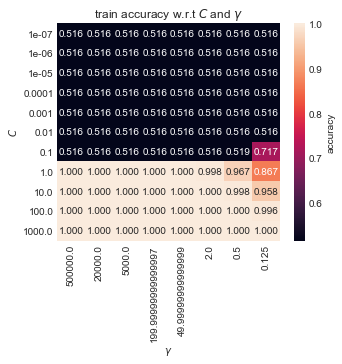

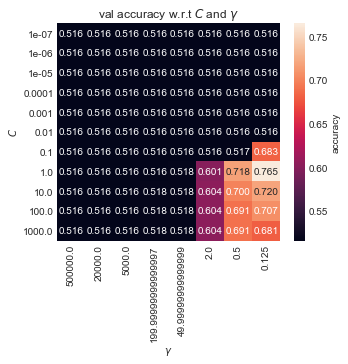

In [13]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()   

train_acc = GSR.cv_results_['mean_train_score'].reshape(11,8)
draw_heatmap_RBF(train_acc, 'train accuracy', gamma_list, C_list)

val_acc = GSR.cv_results_['mean_test_score'].reshape(11,8)
draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)

In [14]:
# KNN
k_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#k_list = [1,5,8]
params = {"n_neighbors": k_list}
knn = KNeighborsClassifier(n_neighbors=26)
kgs=GridSearchCV(knn, params)
knn.fit(X_train_val, Y_train_val)
knn.predict(X_test)

array([ 1.,  0.,  1., ...,  1.,  0.,  0.])

In [15]:
# compute accuracy
test_acc = np.sum(knn.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.71575


In [16]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1024, random_state=0, n_jobs=4)
rf.fit(X_train_val, Y_train_val)
rf.predict(X_test)

array([ 1.,  0.,  1., ...,  1.,  0.,  0.])

In [17]:
# compute accuracy
test_acc = np.sum(rf.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.76525
